In [1]:
using DifferentialEquations;

using ArgParse; # Argument parsing

# Benchmarking & profiling packages
using BenchmarkTools;
using StatProfilerHTML;

# Visualization packages
using DataFrames;
using Plots;
using Gadfly;
using Cairo;
using JLD;

using Statistics;

In [2]:
function meanpositives(mat::Matrix)
    nc = size(mat,1)
    sums = zeros(nc)
    counts = zeros(nc)
    for c in 1:nc
        for r in 1:size(mat,2)
            v = mat[c,r]
            if v > 0
                sums[c] += v
                counts[c] += 1.0
            end
        end
    end
    Float64[(counts[i]>0 ? sums[i]/counts[i] : 0.0) for i in 1:nc]
end

meanpositives (generic function with 1 method)

In [3]:
function stdpositives(mat::Matrix, means::Vector)
    nc = size(mat,1)
    sums = zeros(nc)
    counts = zeros(nc)
    for c in 1:nc
        for r in 1:size(mat,2)
            v = mat[c,r]
            if v > 0
                sums[c] += (v-means[c])^2
                counts[c] += 1.0
            end
        end
    end

    Float64[(counts[i]>0 ? sqrt(sums[i]/counts[i]) : 0.0) for i in 1:nc]
end

stdpositives (generic function with 1 method)

In [4]:
function processAllCell!(allCells, cellMatrixA, cellMatrixC, cellMatrixM)
    for i in 1:lastindex(allCells)
        birthI = floor(Int, 10*allCells[i].birthday)+1;
        fateI = floor(Int, 10*allCells[i].fate_t);
        NuclearRelA = zeros(Float64, 1200);
        NuclearcRel = zeros(Float64, 1200);
        Mass = zeros(Float64, 1200);
        
        if birthI+fateI-1 > birthI
            NuclearRelA[birthI:birthI+fateI-1] .= allCells[i].NuclearRelA;
            NuclearcRel[birthI:birthI+fateI-1] .= allCells[i].NuclearcRel;
            Mass[birthI:birthI+fateI-1] .= allCells[i].Mass;
        
            push!(cellMatrixA, NuclearRelA);
            push!(cellMatrixC, NuclearcRel);
            push!(cellMatrixM, Mass);
        end
    end
end

processAllCell! (generic function with 1 method)

In [5]:
timepoints = [0, 8, 24, 48, 72]
expRelA_CD40h = [1, 9.570835624, 6.647391667, 8.812192916, 9.290313426]
expRelA_CD40l = [1,5.464728524,1.064973305,0.402735158,0.135871011]
expRelA_BCR_CD40h = [1,8.662575164,8.825318836,9.3780265,10.15210103]

expcRel_CD40h = [1,12.76960509,4.205811206,4.813371962,7.088068182]
expcRel_CD40l = [1,4.263613861,0.441887939,0,0.018986274]
expcRel_BCR_CD40h = [1,9.470775203,10.41122862,13.80555243,20.19675405]

timepoints2 = [0, 4, 8, 16, 24, 36, 48, 60, 72]
expcRel_CD40h2 = [1,8.142938138,6.002852823,3.764907576,3.420012959,3.296549614,2.423126766,2.881351356,3.929687359]
timepoints3 = [0, 24, 36, 50, 72.5]
expcRel_BCR_CD40h2 = [1,6.9,6.8,7.2,4.0]

5-element Vector{Float64}:
 1.0
 6.9
 6.8
 7.2
 4.0

┌ Warning: type Cell not present in workspace; interpreting array as Array{Any}
└ @ JLD /Users/helenhuang/.julia/packages/JLD/S6t6A/src/JLD.jl:515
┌ Warning: type Cell not present in workspace; reconstructing
└ @ JLD /Users/helenhuang/.julia/packages/JLD/S6t6A/src/jld_types.jl:697


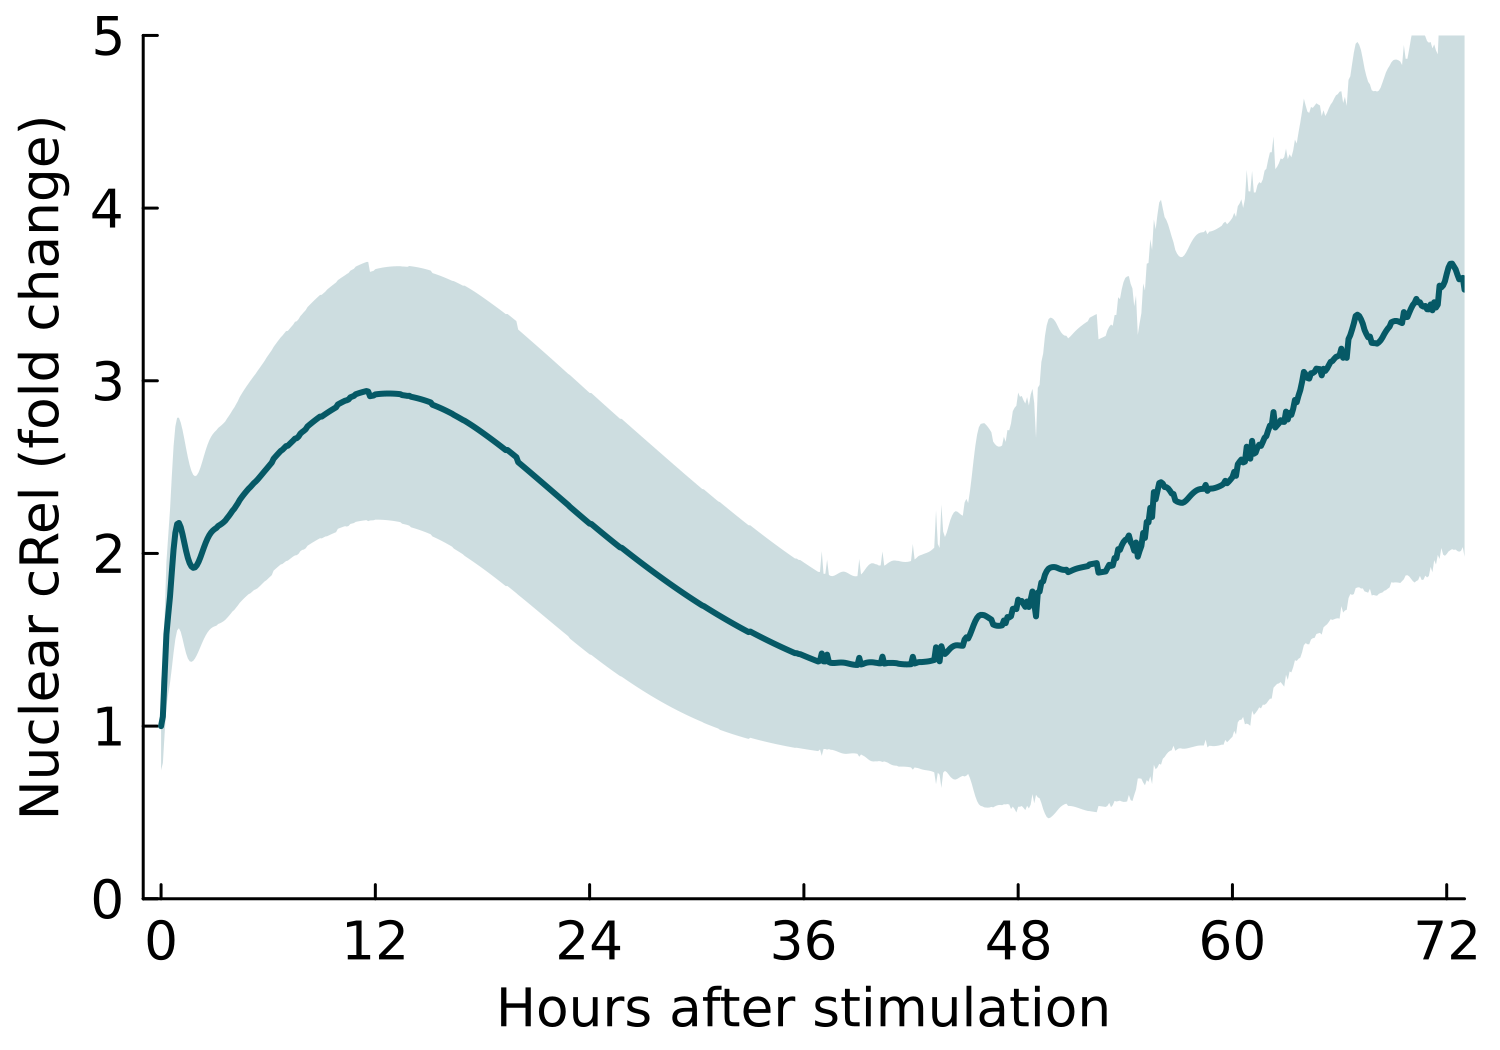

In [26]:
cellMatrixA = Vector{Float64}[];
cellMatrixC = Vector{Float64}[];
cellMatrixM = Vector{Float64}[];

HomeDir = "/Users/helenhuang/Downloads/cells_lineages_125_"
Modifier = "CD40F_H"
# File1 = ["18", "19", "21", "22", "23", "25"]
# File1 = ["1", "2", "4", "5", "6", "7", "8"]
File1 = ["41"]
for i in 1:length(File1)
    cells_fn = string(HomeDir, Modifier, File1[i], ".jld");
    allCells = load(cells_fn, "allCells");
    processAllCell!(allCells, cellMatrixA, cellMatrixC, cellMatrixM);
end

cellMatrixA = reduce(hcat, cellMatrixA);
meanCellsA = meanpositives(cellMatrixA);
baselineA = meanCellsA[1];
NmeanCellsA = meanCellsA / baselineA;
stdCellsA = stdpositives(cellMatrixA, meanCellsA) / baselineA;

cellMatrixC = reduce(hcat, cellMatrixC);
meanCellsC = meanpositives(cellMatrixC);
baselineC = meanCellsC[1];
NmeanCellsC = meanCellsC / baselineC;
stdCellsC = stdpositives(cellMatrixC, meanCellsC) / baselineC;
# cellMatrixM = reduce(hcat, cellMatrixM);
# meanCellsM = meanpositives(cellMatrixM);
# stdCellsM = stdpositives(cellMatrixM, meanCellsM);

plotCellsA = Plots.plot([0:0.1:119.9;], NmeanCellsA, c=RGB(6/255, 89/255, 102/255), size=(500,350), xlabel="Hours after stimulation", ylabel="Nuclear RelA (fold change)",grid=false, xlim=(-1.0, 73.0), ylim=(-1, 20), xticks = ([0:12:72;]), label = "CD40 high", ribbon=stdCellsA, fillalpha=.2, lw = 2, dpi=300, legendfontsize=11, guidefontsize=12, tickfontsize=12, legend=false)
plotCellsC = Plots.plot([0:0.1:119.9;], NmeanCellsC, c=RGB(6/255, 89/255, 102/255), size=(500,350), xlabel="Hours after stimulation", ylabel="Nuclear cRel (fold change)",grid=false, xlim=(-1.0, 73.0), ylim=(0, 5), xticks = ([0:12:72;]), label = "CD40 high", ribbon=stdCellsC, fillalpha=.2, lw = 2, dpi=300, legendfontsize=11, guidefontsize=12, tickfontsize=12, legend=false)

In [7]:
cellMatrixA

1200×5419 Matrix{Float64}:
  5.87964    6.09941    7.19209  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 11.3169    13.8587    14.6103      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 36.2946    48.8073    48.0309      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 67.4315   101.197     79.9815      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 80.8192   152.274     87.6341      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 79.3959   190.94      84.4364   …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 81.1296   208.924     86.6823      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 83.1613   205.41      93.7752      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 82.5075   187.414    104.886       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 79.8322   161.84     116.949       0.0  0.0  0.0  0.0  0.0  0.0  0.0
  ⋮                              ⋱                 ⋮              
  0.0        0.0        0.0         0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0        0.0        0.0         0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0        0.0        0.0         0.0  0.0  0.0  0.0  0.0  0.0  

In [23]:
Plots.plot([0:0.1:2.4;], cellMatrixA[1:25, 1:100], ylim=(0.0, 350.0), legend = false)
savefig("/Users/helenhuang/Downloads/nRelA_rainbow2.png")

In [24]:
Plots.plot([0:0.1:2.4;], cellMatrixC[1:25, 1:100], ylim=(0.0, 150.0), legend = false)
savefig("/Users/helenhuang/Downloads/nRelC_rainbow2.png")

┌ Warning: type Cell not present in workspace; interpreting array as Array{Any}
└ @ JLD /Users/helenhuang/.julia/packages/JLD/S6t6A/src/JLD.jl:515
┌ Warning: type Cell not present in workspace; reconstructing
└ @ JLD /Users/helenhuang/.julia/packages/JLD/S6t6A/src/jld_types.jl:697


┌ Warning: type Cell not present in workspace; interpreting array as Array{Any}
└ @ JLD /Users/helenhuang/.julia/packages/JLD/S6t6A/src/JLD.jl:515
┌ Warning: type Cell not present in workspace; reconstructing
└ @ JLD /Users/helenhuang/.julia/packages/JLD/S6t6A/src/jld_types.jl:697


┌ Warning: type Cell not present in workspace; interpreting array as Array{Any}
└ @ JLD /Users/helenhuang/.julia/packages/JLD/S6t6A/src/JLD.jl:515
┌ Warning: type Cell not present in workspace; reconstructing
└ @ JLD /Users/helenhuang/.julia/packages/JLD/S6t6A/src/jld_types.jl:697


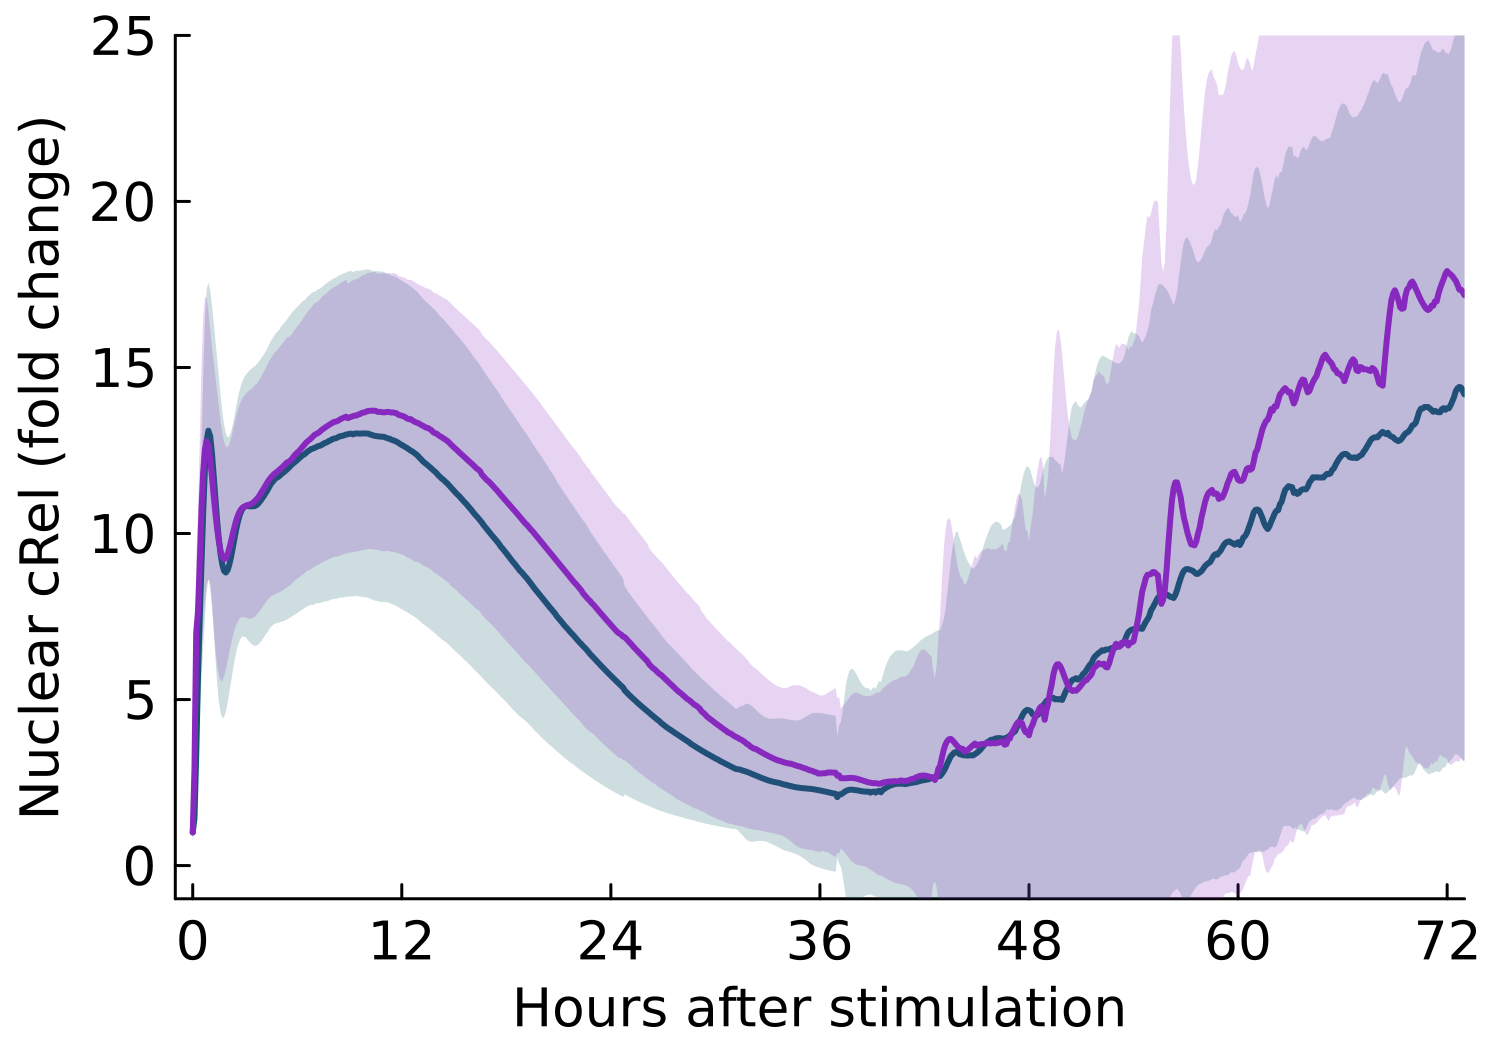

In [74]:
cellMatrixA = Vector{Float64}[];
cellMatrixC = Vector{Float64}[];
cellMatrixM = Vector{Float64}[];

HomeDir = "/Users/helenhuang/Downloads/cells_lineages_125_"
Modifier = "CD40F_HBCR"
# File1 = ["9", "10", "11", "12", "13"]
# File1 = ["17", "18"]
File1 = ["17", "18", "28"]
# File1 = ["27"]
for i in 1:length(File1)
    cells_fn = string(HomeDir, Modifier, File1[i], ".jld");
    allCells = load(cells_fn, "allCells");
    processAllCell!(allCells, cellMatrixA, cellMatrixC, cellMatrixM);
end

cellMatrixA = reduce(hcat, cellMatrixA);
meanCellsA = meanpositives(cellMatrixA);
baselineA = meanCellsA[1];
NmeanCellsA = meanCellsA / baselineA;
stdCellsA = stdpositives(cellMatrixA, meanCellsA) / baselineA;

cellMatrixC = reduce(hcat, cellMatrixC);
meanCellsC = meanpositives(cellMatrixC);
baselineC = meanCellsC[1];
NmeanCellsC = meanCellsC / baselineC;
stdCellsC = stdpositives(cellMatrixC, meanCellsC) / baselineC;
# cellMatrixM = reduce(hcat, cellMatrixM);
# meanCellsM = meanpositives(cellMatrixM);
# stdCellsM = stdpositives(cellMatrixM, meanCellsM);

Plots.plot!(plotCellsA, [0:0.1:119.9;], NmeanCellsA, c=RGB(135/255, 41/255, 190/255), size=(500,350), xlabel="Hours after stimulation", ylabel="Nuclear RelA (fold change)",grid=false, xlim=(-1, 73.0), ylim=(-1, 20), xticks = ([0:12:72;]), label = "BCR + CD40", ribbon=stdCellsA, fillalpha=.2, lw = 2, dpi=300)
Plots.plot!(plotCellsC, [0:0.1:119.9;], NmeanCellsC, c=RGB(135/255, 41/255, 190/255), size=(500,350), xlabel="Hours after stimulation", ylabel="Nuclear cRel (fold change)",grid=false, xlim=(-1, 73.0), ylim=(-1, 25), xticks = ([0:12:72;]), label = "BCR + CD40", ribbon=stdCellsC, fillalpha=.2, lw = 2, dpi=300)

In [75]:
scatter!(plotCellsA, timepoints, expRelA_CD40h, c=RGB(6/255, 89/255, 102/255), markershape=:utriangle,  label = "CD40 high (exp)", markersize = 6)
# scatter!(plotCellsA, timepoints, expRelA_CD40l, c=RGB(37/255, 180/255, 208/255), markershape=:utriangle, label = "CD40 high (exp)", markersize = 6)
scatter!(plotCellsA, timepoints, expRelA_BCR_CD40h, c=RGB(135/255, 41/255, 190/255), markershape=:utriangle, label = "BCR+CD40 (exp)", markersize = 6)
Plots.plot!(plotCellsA)
savefig("/Users/helenhuang/Downloads/nRelA_fates_high.png")

scatter!(plotCellsC, timepoints, expcRel_CD40h, c=RGB(6/255, 89/255, 102/255), markershape=:utriangle,  label = "CD40 high (exp)", markersize = 6)
# scatter!(plotCellsC, timepoints, expcRel_CD40l, c=RGB(37/255, 180/255, 208/255), markershape=:utriangle, label = "CD40 high (exp)", markersize = 6)
scatter!(plotCellsC, timepoints, expcRel_BCR_CD40h, c=RGB(135/255, 41/255, 190/255), markershape=:utriangle, label = "BCR+CD40 (exp)", markersize = 6)
Plots.plot!(plotCellsC)
savefig("/Users/helenhuang/Downloads/ncRel_fates_high.png")

┌ Warning: type Cell not present in workspace; interpreting array as Array{Any}
└ @ JLD /Users/helenhuang/.julia/packages/JLD/S6t6A/src/JLD.jl:515
┌ Warning: type Cell not present in workspace; reconstructing
└ @ JLD /Users/helenhuang/.julia/packages/JLD/S6t6A/src/jld_types.jl:697


┌ Warning: type Cell not present in workspace; interpreting array as Array{Any}
└ @ JLD /Users/helenhuang/.julia/packages/JLD/S6t6A/src/JLD.jl:515
┌ Warning: type Cell not present in workspace; reconstructing
└ @ JLD /Users/helenhuang/.julia/packages/JLD/S6t6A/src/jld_types.jl:697


┌ Warning: type Cell not present in workspace; interpreting array as Array{Any}
└ @ JLD /Users/helenhuang/.julia/packages/JLD/S6t6A/src/JLD.jl:515
┌ Warning: type Cell not present in workspace; reconstructing
└ @ JLD /Users/helenhuang/.julia/packages/JLD/S6t6A/src/jld_types.jl:697


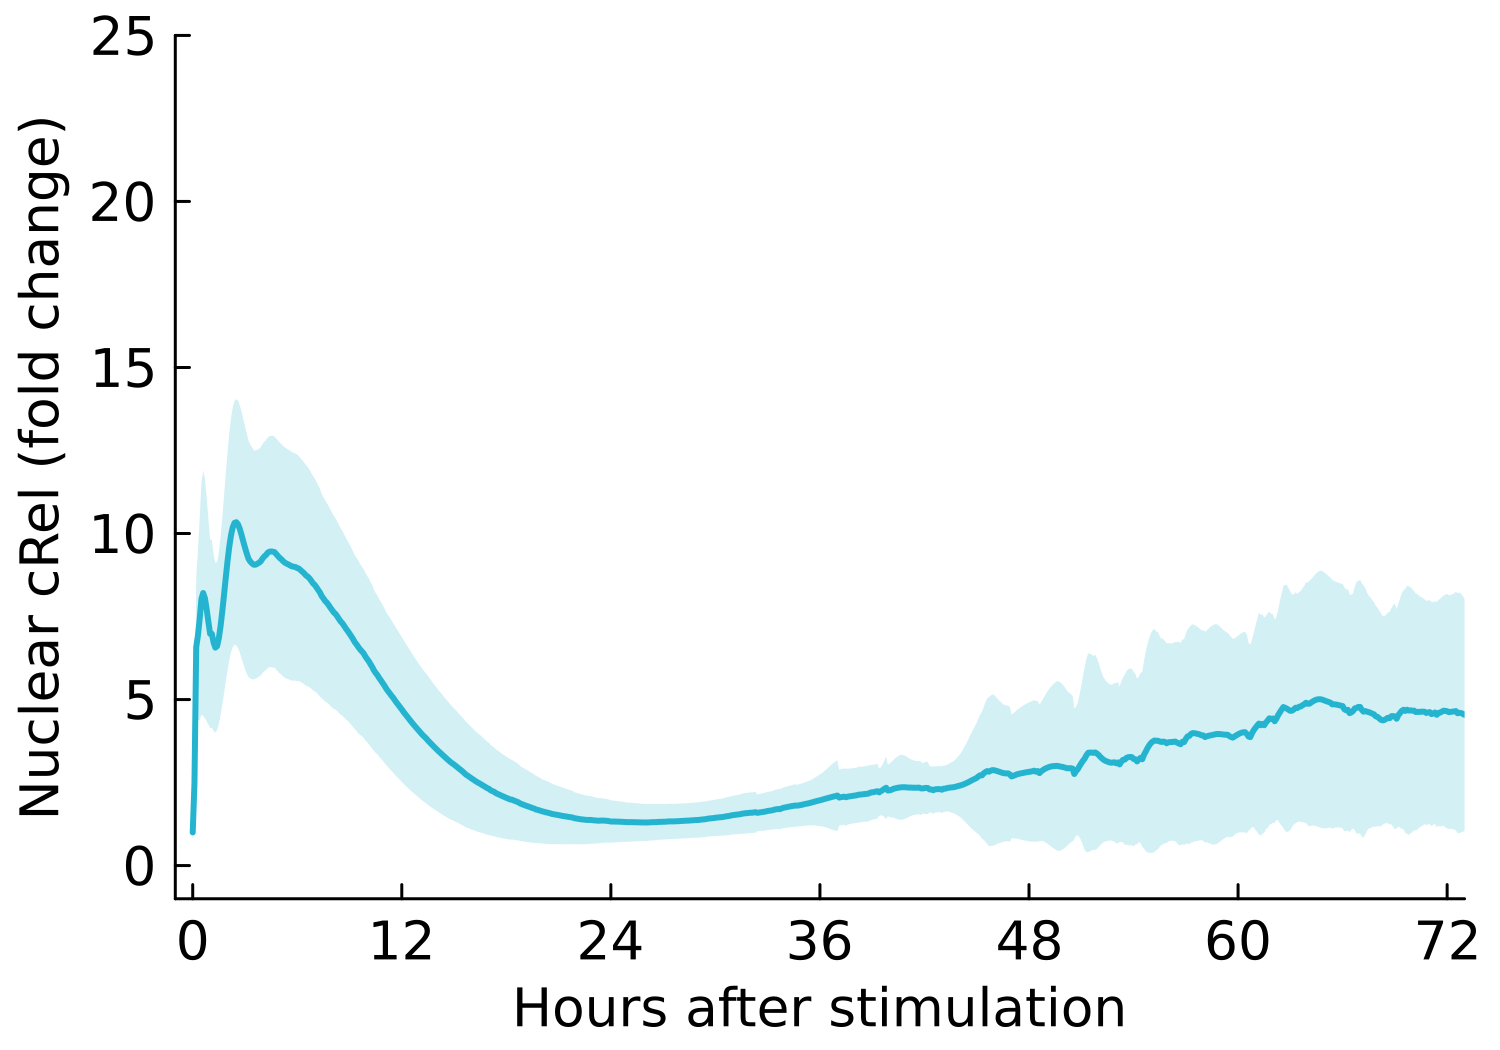

In [86]:
cellMatrixA = Vector{Float64}[];
cellMatrixC = Vector{Float64}[];
cellMatrixM = Vector{Float64}[];

HomeDir = "/Users/helenhuang/Downloads/cells_lineages_125_"
Modifier = "CD40F_L"
Modifier = "LCD40_HBCR_1hr_"
File1 = ["1", "2", "3", "4", "5", "6", "7", "8"]
File1 = ["10", "11","12"]
for i in 1:length(File1)
    cells_fn = string(HomeDir, Modifier, File1[i], ".jld");
    allCells = load(cells_fn, "allCells");
    processAllCell!(allCells, cellMatrixA, cellMatrixC, cellMatrixM);
end

cellMatrixA = reduce(hcat, cellMatrixA);
meanCellsA = meanpositives(cellMatrixA);
baselineA = meanCellsA[1];
NmeanCellsA = meanCellsA / baselineA;
stdCellsA = stdpositives(cellMatrixA, meanCellsA) / baselineA;

cellMatrixC = reduce(hcat, cellMatrixC);
meanCellsC = meanpositives(cellMatrixC);
baselineC = meanCellsC[1];
NmeanCellsC = meanCellsC / baselineC;
stdCellsC = stdpositives(cellMatrixC, meanCellsC) / baselineC;
# cellMatrixM = reduce(hcat, cellMatrixM);
# meanCellsM = meanpositives(cellMatrixM);
# stdCellsM = stdpositives(cellMatrixM, meanCellsM);

plotCellsA = Plots.plot([0:0.1:119.9;], NmeanCellsA, c=RGB(37/255, 180/255, 208/255), size=(500,350), xlabel="Hours after stimulation", ylabel="Nuclear RelA (fold change)",grid=false, xlim=(-1, 73.0), ylim=(-1, 20), xticks = ([0:12:72;]), label = "CD40 low", ribbon=stdCellsA, fillalpha=.2, lw = 2, dpi=300, legend=false, legendfontsize=11, guidefontsize=12, tickfontsize=12)
plotCellsC = Plots.plot([0:0.1:119.9;], NmeanCellsC, c=RGB(37/255, 180/255, 208/255), size=(500,350), xlabel="Hours after stimulation", ylabel="Nuclear cRel (fold change)",grid=false, xlim=(-1, 73.0), ylim=(-1, 25), xticks = ([0:12:72;]), label = "CD40 low", ribbon=stdCellsC, fillalpha=.2, lw = 2, dpi=300, legend=false, legendfontsize=11, guidefontsize=12, tickfontsize=12)

┌ Warning: type Cell not present in workspace; interpreting array as Array{Any}
└ @ JLD /Users/helenhuang/.julia/packages/JLD/S6t6A/src/JLD.jl:515
┌ Warning: type Cell not present in workspace; reconstructing
└ @ JLD /Users/helenhuang/.julia/packages/JLD/S6t6A/src/jld_types.jl:697


┌ Warning: type Cell not present in workspace; interpreting array as Array{Any}
└ @ JLD /Users/helenhuang/.julia/packages/JLD/S6t6A/src/JLD.jl:515
┌ Warning: type Cell not present in workspace; reconstructing
└ @ JLD /Users/helenhuang/.julia/packages/JLD/S6t6A/src/jld_types.jl:697


┌ Warning: type Cell not present in workspace; interpreting array as Array{Any}
└ @ JLD /Users/helenhuang/.julia/packages/JLD/S6t6A/src/JLD.jl:515
┌ Warning: type Cell not present in workspace; reconstructing
└ @ JLD /Users/helenhuang/.julia/packages/JLD/S6t6A/src/jld_types.jl:697


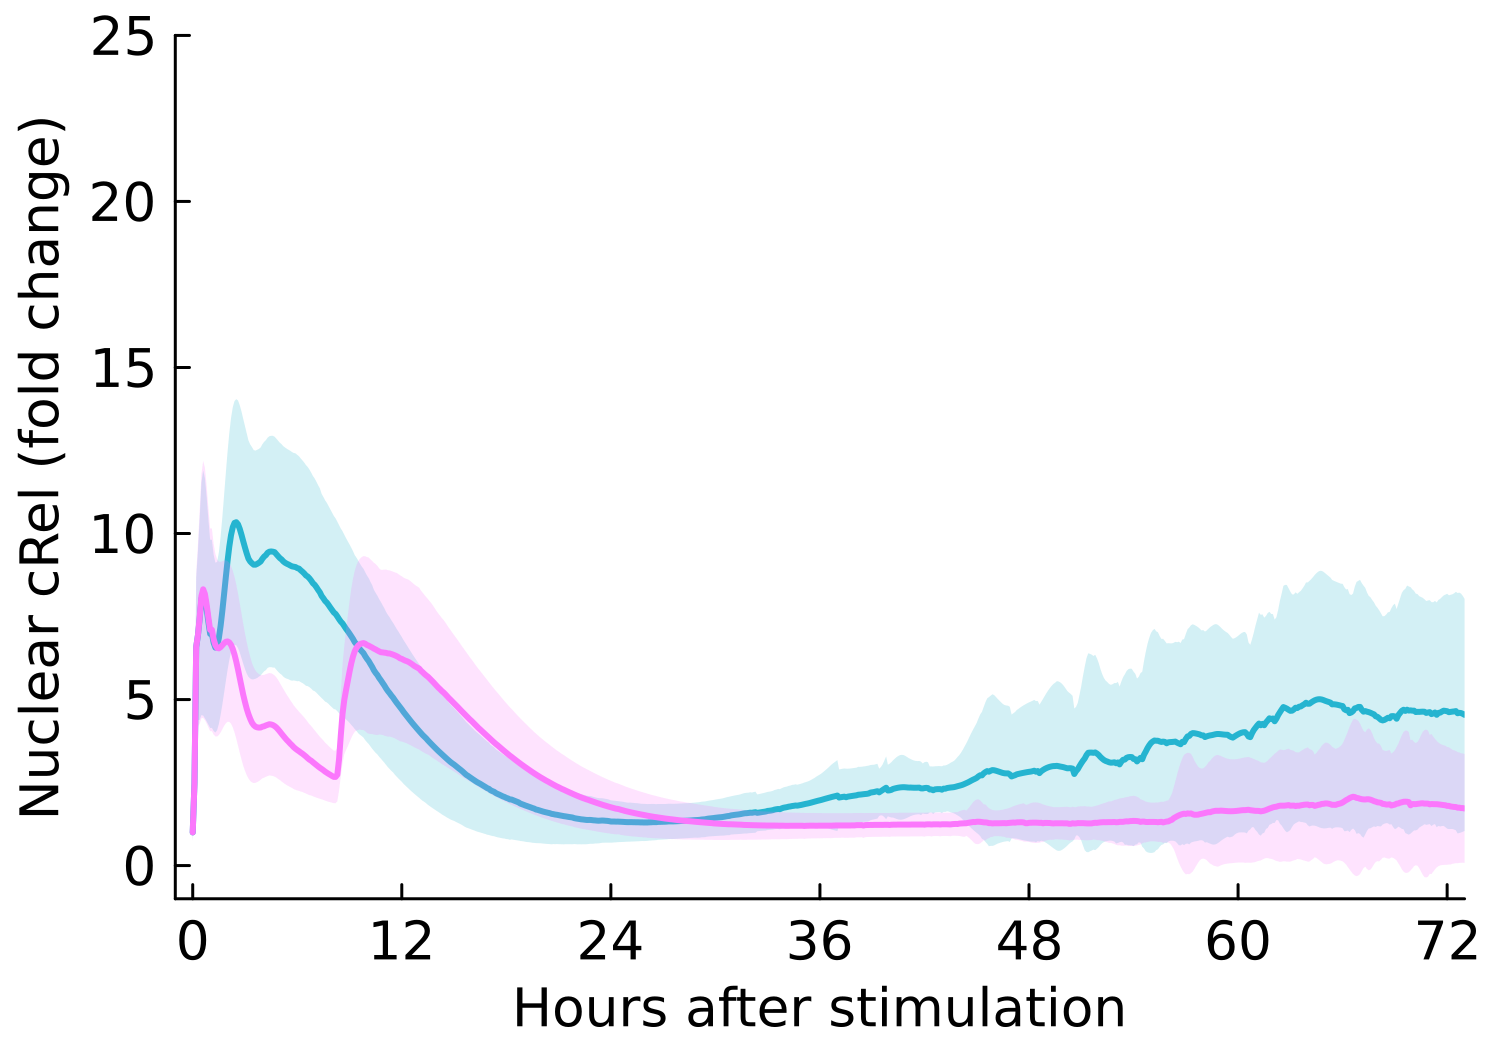

In [87]:
cellMatrixA = Vector{Float64}[];
cellMatrixC = Vector{Float64}[];
cellMatrixM = Vector{Float64}[];

HomeDir = "/Users/helenhuang/Downloads/cells_lineages_125_"
Modifier = "CD40F_LBCR"
Modifier = "LCD40_HBCR_8hr_"
File1 = ["1", "2", "3", "4", "5", "6", "7"]
File1 = ["9", "11", "12"]
for i in 1:length(File1)
    cells_fn = string(HomeDir, Modifier, File1[i], ".jld");
    allCells = load(cells_fn, "allCells");
    processAllCell!(allCells, cellMatrixA, cellMatrixC, cellMatrixM);
end

cellMatrixA = reduce(hcat, cellMatrixA);
meanCellsA = meanpositives(cellMatrixA);
baselineA = meanCellsA[1];
NmeanCellsA = meanCellsA / baselineA;
stdCellsA = stdpositives(cellMatrixA, meanCellsA) / baselineA;

cellMatrixC = reduce(hcat, cellMatrixC);
meanCellsC = meanpositives(cellMatrixC);
baselineC = meanCellsC[1];
NmeanCellsC = meanCellsC / baselineC;
stdCellsC = stdpositives(cellMatrixC, meanCellsC) / baselineC;
# cellMatrixM = reduce(hcat, cellMatrixM);
# meanCellsM = meanpositives(cellMatrixM);
# stdCellsM = stdpositives(cellMatrixM, meanCellsM);

Plots.plot!(plotCellsA, [0:0.1:119.9;], NmeanCellsA, c=RGB(251/255, 119/255, 252/255), size=(500,350), xlabel="Hours after stimulation", ylabel="Nuclear RelA (fold change)",grid=false, xlim=(-1, 73.0), ylim=(-1, 20), xticks = ([0:12:72;]), label = "BCR + CD40", ribbon=stdCellsA, fillalpha=.2, lw = 2, dpi=300, legend=false)
Plots.plot!(plotCellsC, [0:0.1:119.9;], NmeanCellsC, c=RGB(251/255, 119/255, 252/255), size=(500,350), xlabel="Hours after stimulation", ylabel="Nuclear cRel (fold change)",grid=false, xlim=(-1, 73.0), ylim=(-1, 25), xticks = ([0:12:72;]), label = "BCR + CD40", ribbon=stdCellsC, fillalpha=.2, lw = 2, dpi=300, legend=false)

In [78]:
scatter!(plotCellsA, timepoints, expRelA_CD40l, c=RGB(37/255, 180/255, 208/255), markershape=:utriangle, label = "CD40 low (exp)", markersize = 6)
Plots.plot!(plotCellsA)
savefig("/Users/helenhuang/Downloads/nRelA_fates_low2.png")
scatter!(plotCellsC, timepoints, expcRel_CD40l, c=RGB(37/255, 180/255, 208/255), markershape=:utriangle, label = "CD40 low (exp)", markersize = 6)
Plots.plot!(plotCellsC)
savefig("/Users/helenhuang/Downloads/ncRel_fates_low2.png")

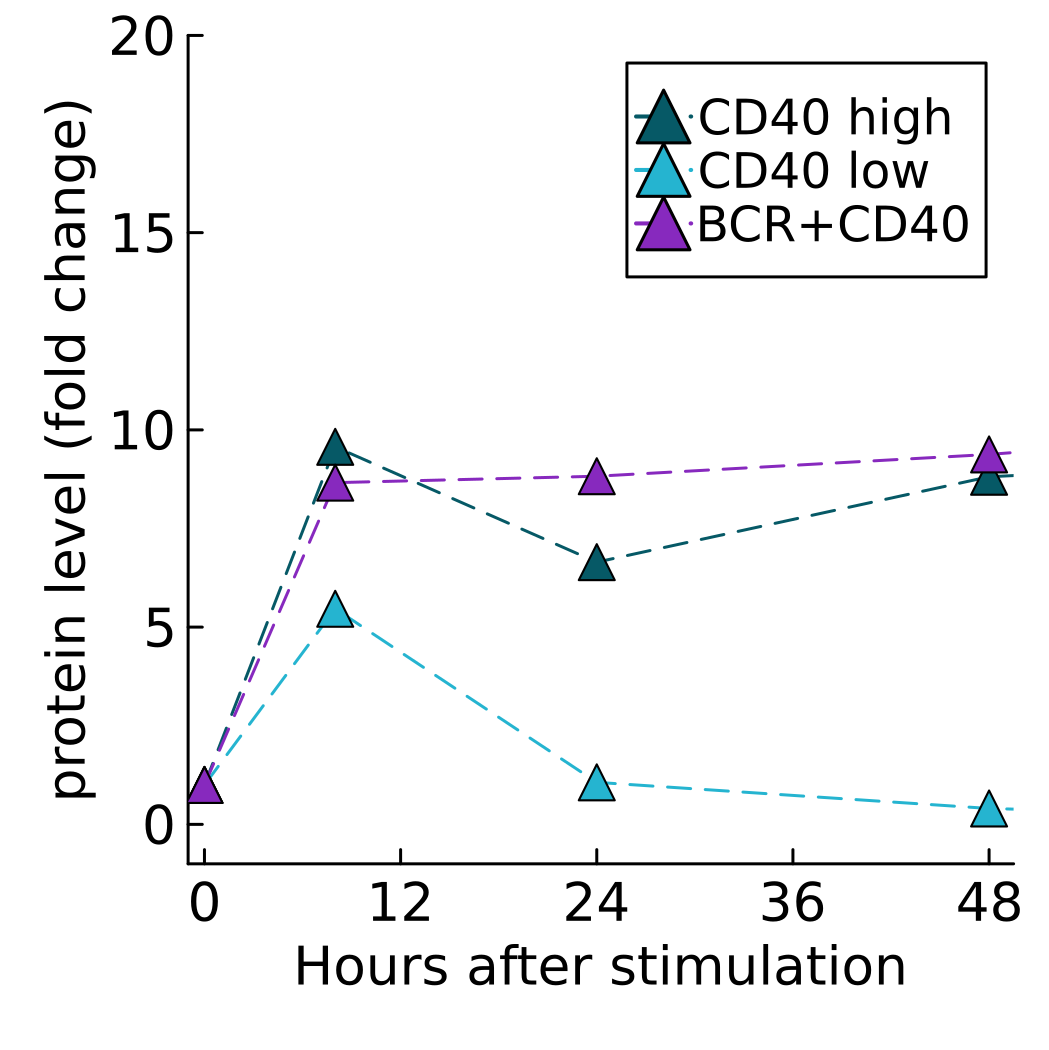

In [79]:

plotCellsA_western = Plots.plot(timepoints, expRelA_CD40h, c=RGB(6/255, 89/255, 102/255), xlabel="Hours after stimulation", ylabel="protein level (fold change)",grid=false, size=(350,350), xlim=(-1, 49.5), ylim=(-1, 20), xticks = ([0:12:72;]), markershape=:utriangle, linestyle=:dash, label = "CD40 high", markersize = 6, dpi=300, legendfontsize=11, guidefontsize=12, tickfontsize=12)
Plots.plot!(plotCellsA_western, timepoints, expRelA_CD40l, c=RGB(37/255, 180/255, 208/255), markershape=:utriangle, linestyle=:dash, label = "CD40 low", markersize = 6)
Plots.plot!(plotCellsA_western, timepoints, expRelA_BCR_CD40h, c=RGB(135/255, 41/255, 190/255), markershape=:utriangle, linestyle=:dash, label = "BCR+CD40", markersize = 6)
# savefig("/Users/helenhuang/Downloads/nRelA_western.png")

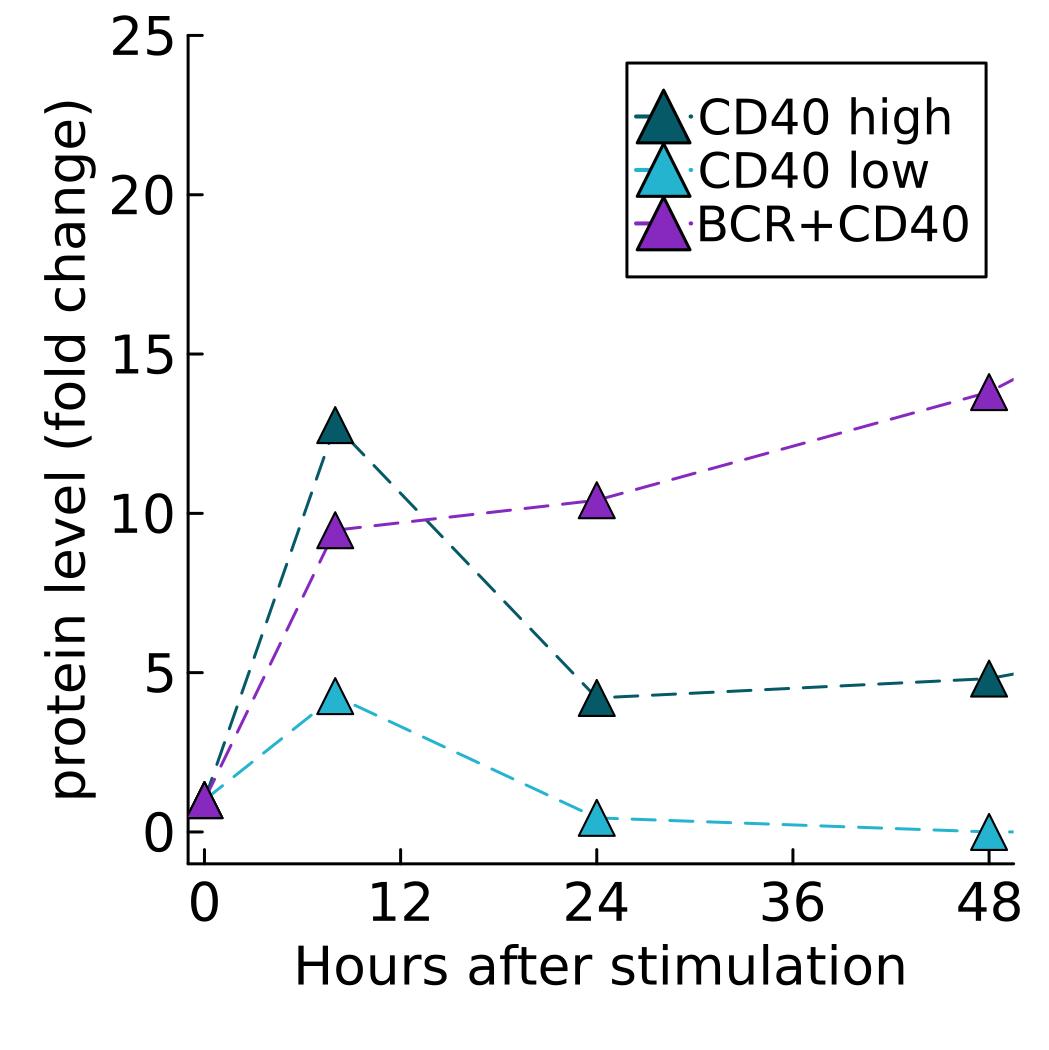

In [80]:
plotCellsC_western = Plots.plot(timepoints, expcRel_CD40h, c=RGB(6/255, 89/255, 102/255), xlabel="Hours after stimulation", ylabel="protein level (fold change)",grid=false, size=(350,350), xlim=(-1, 49.5), ylim=(-1, 25), xticks = ([0:12:72;]), markershape=:utriangle, linestyle=:dash, label = "CD40 high", markersize = 6, dpi=300, legendfontsize=11, guidefontsize=12, tickfontsize=12)
Plots.plot!(plotCellsC_western, timepoints, expcRel_CD40l, c=RGB(37/255, 180/255, 208/255), markershape=:utriangle, linestyle=:dash, label = "CD40 low", markersize = 6)
Plots.plot!(plotCellsC_western, timepoints, expcRel_BCR_CD40h, c=RGB(135/255, 41/255, 190/255), markershape=:utriangle, linestyle=:dash, label = "BCR+CD40", markersize = 6)
# savefig("/Users/helenhuang/Downloads/ncRel_western.png")